In [1]:
import torch
from torch import nn
from torch.nn import Parameter
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
import time

cuda = torch.cuda.is_available()
print(cuda)

True


In [2]:
class RNN(nn.Module):
    def __init__(self, input_size=9, hidden_size=100, output_size=9):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = torch.nn.functional.sigmoid
        self.hidden_state0 = Parameter(torch.zeros(1, hidden_size)).float()
        self.cell_state0 = Parameter(torch.zeros(1, hidden_size)).float()

    def step(self, input_vector, hidden_state, cell_state):
        hidden_state, cell_state = self.LSTM(input_vector, (hidden_state, cell_state))
        return hidden_state, cell_state, self.fc(hidden_state)
    
    def forward(self, input_vectors):
        N = input_vectors.shape[0]
        T = input_vectors.shape[1] - 1
        
        hidden_state = self.hidden_state0.expand(N, self.hidden_size)
        cell_state = self.cell_state0.expand(N, self.hidden_size)
        
        for t in range(T + 1):
            hidden_state, cell_state, _ = self.step(input_vectors[:, t, :], hidden_state, cell_state)
        
        zero_vector = Variable(torch.from_numpy(np.zeros((N, 9)))).float()
        
        outputs = []
        for t in range(T):
            hidden_state, cell_state, output = self.step(zero_vector, hidden_state, cell_state)
            outputs.append(self.activation(output.unsqueeze(2).transpose(1, 2)))
        return torch.cat(outputs, 1)

rnn = RNN(9, 100, 9)

In [3]:
# inputs 
all_vectors = []
T = 10
n = 200000

X = np.random.randint(0, 2, (n, T + 1, 9)).astype(float)
X[:, :, -1] = np.array(T*[0]+[1])
X[:, -1, :-1] = np.array(8 * [0])
input_vectors = Variable(torch.from_numpy(X)).float()

In [4]:
X.shape

(200000, 11, 9)

In [5]:
input_vectors = Variable(torch.from_numpy(X)).float()
print(input_vectors.shape)
#ut = rnn(input_vectors)

torch.Size([200000, 11, 9])


In [6]:
import math
def random_mini_batches_idx(m=n, mini_batch_size = 64):
    permutation = np.random.permutation(m)
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) 
    list_of_indices = []
    for k in range(0, num_complete_minibatches):
        list_of_indices.append(np.array(list(permutation[k * mini_batch_size: k * mini_batch_size + mini_batch_size])))
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        list_of_indices.append(np.array(list(permutation[num_complete_minibatches * mini_batch_size : m])))
    return list_of_indices

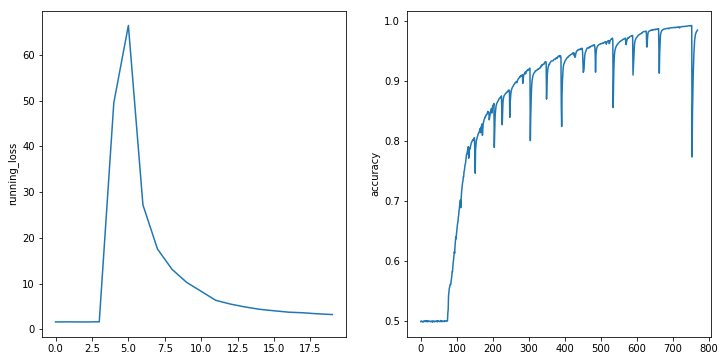

[41,    90] loss: 3.2280, approx accuracy: 0.9847, norms of weights: 295.17
Variable containing:
(0 ,.,.) = 

Columns 0 to 5 
   3.5483e-03  1.0000e+00  1.0000e+00  6.1485e-02  9.9989e-01  5.5941e-01
  1.0000e+00  9.9980e-01  4.0716e-07  9.8691e-01  5.5107e-13  1.5900e-03
  9.9870e-01  9.9972e-01  9.7796e-05  9.4703e-01  1.4583e-02  9.7814e-04
  2.7632e-06  9.5553e-09  9.9994e-01  1.1121e-02  1.2086e-01  4.5453e-04
  6.6599e-07  9.9395e-01  9.5928e-01  9.8912e-01  5.7278e-02  8.1994e-04
  7.5963e-03  9.9856e-01  1.2025e-02  4.4856e-01  9.5580e-01  3.7893e-02
  9.9869e-01  1.7549e-04  8.8231e-01  1.0000e+00  9.9996e-01  6.0573e-07
  9.9998e-01  9.9998e-01  6.0467e-02  5.5519e-03  6.1414e-08  9.9988e-01
  9.9732e-01  1.0000e+00  9.9997e-01  1.0000e+00  2.5564e-02  9.9977e-01
  9.9937e-01  9.4412e-01  1.0000e+00  9.9997e-01  9.9999e-01  3.1560e-03

Columns 6 to 7 
   1.0414e-03  4.7885e-05
  7.0157e-08  9.4030e-01
  1.4103e-07  9.9915e-01
  9.9333e-01  3.0332e-02
  9.9996e-01  3.3968e-04


In [ ]:
cuda = False
lr = 0.01
n_epochs = 100
criterion = torch.nn.BCELoss()
rnn = RNN()
optimizer = torch.optim.Adam(rnn.parameters(),  lr=lr)
print_every = 10
if cuda:
    print('Using CUDA')
    rnn = rnn.cuda()
    input_vectors = input_vectors.cuda()
accuracies = []
running_losses = []
lossfct = nn.functional.binary_cross_entropy
for epoch in range(n_epochs):
    minibatches_indices = random_mini_batches_idx(n, mini_batch_size=1024)
    running_loss = 0.0
    #running_bce_loss = 0.0
    for i, indices in enumerate(minibatches_indices):
        minibatch = input_vectors[indices, :, :]
    #print(list(rnn.parameters())[1])
    #print(input_vectors)
        optimizer.zero_grad()
        outputs = rnn(minibatch)
        #print(input_vectors[:-1,:].shape)
        loss = lossfct(outputs[:, :, :], minibatch[:, :-1, :], size_average=False)
        #loss = - torch.sum(minibatch[:, :-1, :] * torch.log(outputs) + (1 - minibatch[:, :-1, :]) * torch.log(1 - outputs))
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]/len(minibatch)
        #running_bce_loss += bceloss.data[0]/len(minibatch)
        if i % print_every == print_every - 1: 
            norms_of_weights = [torch.norm(x[1].data) for x in list(rnn.named_parameters()) if 'weight' in x[0]]
            accuracy_approx = torch.mean(((rnn(input_vectors[:10000,:,:])[:,:,:-1] > .5).float() == input_vectors[:10000, :-1, :-1] ).float())
            running_losses.append(running_loss/print_every)
            
            accuracies.append(accuracy_approx.data[0])
            
            plt.clf()
            plt.subplot(1,2,1)
            plt.plot(running_losses[-20:])
            plt.ylabel("running_loss")
            plt.subplot(1,2,2)
            plt.plot(accuracies)
            plt.ylabel("accuracy")
            plt.gcf().set_size_inches((12,6))
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print('[%d, %5d] loss: %.4f, approx accuracy: %.4f, norms of weights: %.2f' % (epoch + 1,
                                                                                           i + 1,
                                                                                           running_loss / print_every,
                                                                                           accuracy_approx,
                                                                                           sum(norms_of_weights)))
            print(rnn(input_vectors[:1,:,:])[:,:,:-1], input_vectors[:1, :-1, :-1])
            running_loss = 0.0
            time.sleep(0.01)